Este archivo es para implementar algunos algoritmos de aprendizaje por refuerzo y aplicarlos utilizando Open AI gym.

Se van a probar los siguientes 2 entornos (environments), de acuerdo con los resultados presentados en el articulo de Diego:

Pendulum-v0 y Hopper-v2

Tareas (Puede cambiar):
1. Terminar el curso de David Silver. (Completo: 100%)
2. Implementar con table lookup. (Completo: 100%)
3. Implementar con DQN. (Completo: 100%)
4. Implementar con Simglucose (En progreso: No ha funcionado)
5. Implementar en Pytorch (En progreso: 10%)
6. Implementar con el trabajo de Diego. (En progreso: 10%)

7. Adicional: Optimizar el codigo. 

# Instalación

In [1]:
#Correr esta celda si se utiliza Google Colab con un ambiente remoto.
!pip install progressbar2
!pip install gym

# Librerías

In [1]:
import time, copy, random
import numpy as np
import pandas as pd

import progressbar
import gym

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras.initializers import RandomNormal

%matplotlib inline
import matplotlib.pyplot as plt

/home/hero/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/hero/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/hero/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/hero/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (

# Clases

In [2]:
class ExperienceReplay():
    def __init__(self, tamano_minimo = 1000, tamano_maximo = 10**5, tamano_batch = 32, column_names = ['St', 'At', 'St+1', 'Rt+1', 'done']):
        self.tamano_buffer = 0
        self.indice = 0
        self.tamano_batch = tamano_batch
        self.tamano_minimo = tamano_minimo
        self.tamano_maximo = tamano_maximo
        self.columnas = column_names
        
        self.buffer = self.inicializarBuffer()
        self.buffer.columns = column_names
        #self.indices = range(self.tamano_maximo)
    
    def inicializarBuffer(self):
        aux = pd.DataFrame(np.zeros((10**4,5)), dtype = 'object')
        #aux = pd.DataFrame({'St': None, 'At': [np.array([0,0])],
        #                   'Rt+1': [np.array([0,0])], 'St+1': [np.array([0,0])],
        #                   'done': [np.array([0,0])]})
        
        buffer = []
        
        for i in range(int(self.tamano_maximo/10**4)):
            buffer.append(aux)
        
        return pd.concat(buffer)
    
    def agregarDato(self, x, a, r, xp, d):
        
        if(self.indice == self.tamano_maximo):
            self.indice = 0
            
        self.buffer.iloc[self.indice]['St'] = x
        self.buffer.iloc[self.indice]['At'] = a
        self.buffer.iloc[self.indice]['Rt+1'] = r
        self.buffer.iloc[self.indice]['St+1'] = xp
        self.buffer.iloc[self.indice]['done'] = d

        self.indice +=1
        
        if self.tamano_buffer < self.tamano_maximo:
            self.tamano_buffer += 1
    
    def darMuestras(self):
        #indices = random.sample(self.indices[0:self.tamano_buffer], self.tamano_batch)
        indices = random.sample(range(self.tamano_buffer), self.tamano_batch)
        return self.buffer.iloc[indices]


# Table Lookup

Pendulum-v0<br /> 
Utilizando el algoritmo de Sarsa.<br />
Está como chambón pero funciona.

In [ ]:
def darIndice(pS):
    return int(round(pS, 1)*10+10)

def escogerAccion(pS1, pS2, pS3):
    num = np.random.random()
    
    if(num <= epsilon):
        ind = np.random.randint(0,41)
        return ind
    else:
        ind = np.where(tablaQ[pS1, pS2, pS3, :] == np.amax(tablaQ[pS1, pS2, pS3, :]))
        ind = ind[0]
        
        if(len(ind) > 1):
            return np.random.choice(ind)
        else:
            return ind
    
    return accion

In [ ]:
envName = 'Pendulum-v0'

g = 0.9
alpha = 0.5
epsilon = 0.1 #Entre 0 y 1
maxIter = 1500000
ventana = 100
epsilonIterLimit = maxIter*0.9

tablaQ = np.ones((21,21,17,41))*-16
rewards = np.zeros(int(maxIter/10))

env = gym.make(envName)
observation = env.reset()

s1 = darIndice(observation[0])
s2 = darIndice(observation[1])
s3 = int(round(observation[2], 0) + 8)
a = escogerAccion(s1, s2, s3)

suma = 0

for i in progressbar.progressbar(range(maxIter)):
    
    if(i > maxIter-2000):
        env.render()
    
    observation, reward, done, info = env.step([(a-20)/10.0])
    observation = np.reshape(observation, (3,))
    
    s1p = darIndice(observation[0])
    s2p = darIndice(observation[1])
    s3p = int(round(observation[2], 0) + 8)
    
    ap = escogerAccion(s1p, s2p, s3p)
    
    r = reward #Por ahora
    suma+=r
    
    if(i % ventana == 0):
        rewards[int(i/ventana)] = suma/ventana
        suma = 0
    
    tablaQ[s1, s2, s3, a] = tablaQ[s1, s2, s3, a] + alpha*(r + g*tablaQ[s1p, s2p, s3p, ap] - tablaQ[s1,s2,s3,a])
    
    s1 = s1p
    s2 = s2p
    s3 = s3p
    a = ap
    
    if(i > epsilonIterLimit):
        epsilon = 0
    
env.close()

In [ ]:
for i in progressbar.progressbar(range(2000)):
    env.render()
    
    observation, reward, done, info = env.step([(a-20)/10.0])
    observation = np.reshape(observation, (3,))
    
    s1p = darIndice(observation[0])
    s2p = darIndice(observation[1])
    s3p = int(round(observation[2], 0) + 8)
    
    ap = escogerAccion(s1p, s2p, s3p)
    
    r = reward #Por ahora
    suma+=r
    
    if(i % ventana == 0):
        rewards[int(i/ventana)] = suma/ventana
        suma = 0
    
    tablaQ[s1, s2, s3, a] = tablaQ[s1, s2, s3, a] + alpha*(r + g*tablaQ[s1p, s2p, s3p, ap] - tablaQ[s1,s2,s3,a])
    
    s1 = s1p
    s2 = s2p
    s3 = s3p
    a = ap
    
env.close()

# DQN

In [3]:
envName = 'Pendulum-v0'
env = gym.make(envName) 

num_acciones = 41
dim_state = 3

#Creando redes neuronales
def crearRedes(n1 = 20, n2 = num_acciones, learning_rate = 0.01):
    init = RandomNormal(seed = 0)
    
    modelo = Sequential()
    
    modelo.add(Dense(n1, activation = 'relu', kernel_initializer = init, bias_initializer = init, input_dim = dim_state))
    modelo.add(Dense(n1, activation = 'relu', kernel_initializer = init, bias_initializer = init))
    modelo.add(Dense(n2, activation = 'linear', kernel_initializer = init, bias_initializer = init))
    
    sgd = optimizers.sgd(lr = learning_rate)
    
    modelo.compile(loss = 'mean_squared_error', optimizer = sgd, metrics = ['accuracy'])
    
    return modelo, copy.deepcopy(modelo)

def actualizarRedTarget(pRedPrincipal, pRedTarget):
    
    for i in range(len(pRedPrincipal.layers)):
        pesosPrincipal = pRedPrincipal.layers[i].get_weights()
        pesosTarget = pRedTarget.layers[i].get_weights()
        
        pesos = [tao*l1 + (1-tao)*l2 for l1, l2 in zip(pesosPrincipal, pesosTarget)]
        
        pRedTarget.layers[i].set_weights(pesos)

def escogerAccion(pModelo, pX):
    num = np.random.random()
    
    if(num <= epsilon):
        ind = np.random.randint(0, num_acciones)
        return ind
    else:
        ind = np.argmax(pModelo.predict(pX))
        return ind

/home/hero/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Entrenando el Agente

100% (2000 of 2000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:09:44 Time:  0:09:44


Total training time:  585.86 seconds


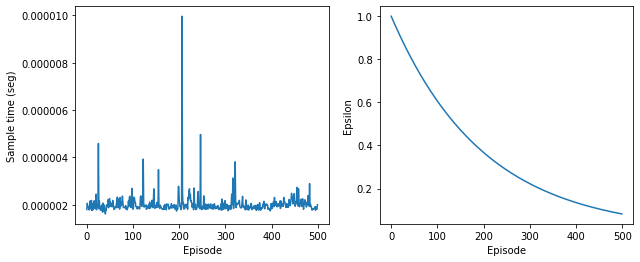

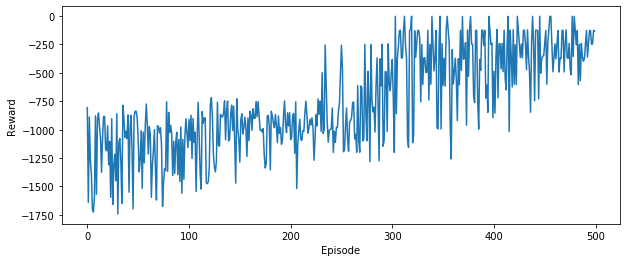

In [17]:
np.random.seed(123)

buffer = ExperienceReplay(tamano_minimo = 2000)

red, red_target = crearRedes(learning_rate = 0.05)

num_episodes = 500
num_steps = 500
epsilon = 1.0
epsilon_decay = 0.995
tao = 0.001
gamma = 0.99
batch_size = 32

total_steps_log = []
epsilon_log = []
muestras_log = []
rewards_acumulados = []

state = env.reset()

state[2] *= 1/8.0
state = np.reshape(state, (1,-1))

initial_time = time.time()

for s in progressbar.progressbar(range(buffer.tamano_minimo)):
    action = np.random.randint(num_acciones)
    
    next_state, reward, done, info = env.step([(action-20.0)/10.0])
    next_state[2] *= 1/8.0
    next_state = np.reshape(next_state, (1, -1))
    
    buffer.agregarDato(state, action, reward, next_state, done)
    
    state = next_state

for e in progressbar.progressbar(range(num_episodes)):
    state = env.reset()
    state[2] *= 1/8.0
    state = np.reshape(state, (1, -1))
    
    rewardAcumulado = 0
    
    for s in range(num_steps):
        if(np.random.random() <= epsilon):
            action = np.random.randint(num_acciones)
        else:
            action = np.argmax(red.predict(state))
            
        next_state, reward, done, info = env.step([(action-20.0)/10.0])
        next_state[2] *= 1/8.0
        next_state = np.reshape(next_state, (1, -1))
        
        buffer.agregarDato(state, action, reward, next_state, done)
       
        state = next_state
        
        sumaMuestras = 0
        
        tm = time.time()
        muestras = buffer.darMuestras()
        sumaMuestras += time.time()-tm

        states = np.concatenate(muestras['St'].values)
        actions = muestras['At'].values
        rewards = muestras['Rt+1'].values
        next_states = np.concatenate(muestras['St+1'].values)
        dones = muestras['done'].values

        Q_values = red.predict(states)

        next_Q_values = red_target.predict(next_states)
        targets = Q_values.copy()   # Set initial target values

        targets[np.arange(buffer.tamano_batch), list(actions)] = rewards + gamma* np.max(next_Q_values, axis = 1) * (1 - dones)

        red.train_on_batch(states, targets)

        actualizarRedTarget(red, red_target)

        rewardAcumulado += reward
        
        if(done):
            break    
    
    sumaMuestras *= 1/float(s)
    muestras_log.append(sumaMuestras)
    rewards_acumulados.append(rewardAcumulado)
    
    total_steps_log.append(s)
    epsilon_log.append(epsilon)
    epsilon = epsilon_decay * epsilon

total_training_time = time.time() - initial_time

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(muestras_log)
plt.xlabel('Episode')
plt.ylabel('Sample time (seg)')

plt.subplot(122)
plt.plot(epsilon_log)
plt.xlabel('Episode')
plt.ylabel('Epsilon')

plt.figure(figsize=(10,4))
plt.plot(rewards_acumulados)
plt.xlabel('Episode')
plt.ylabel('Reward')

print('Total training time: ', np.round(total_training_time, 2), 'seconds')

# Probando el Agente

In [20]:
steps_prueba = 250

state = env.reset()
state[2] *= 1/8.0
state = np.reshape(state, (1, -1))

for s in range(steps_prueba):
    
    action = np.argmax(red.predict(state))
    state, reward, done, info = env.step([(action-20.0)/10.0])
    
    state[2] *= 1/8.0
    state = np.reshape(state, (1, -1))

    env.render()
    
env.close()

# PyTorch

In [1]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Bien")

Bien


In [2]:
print(device)

cuda


In [4]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1,6,3)
        self.conv2 = nn.Conv2d(6,16,3)
        
        self.fc1 = nn.Linear(16*6*6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        
        for s in size:
            num_features *= s
        return num_features
    
net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
params = list(net.parameters())
print(len(params))
print(params[2].size())

10
torch.Size([16, 6, 3, 3])


In [15]:
input_data = torch.randn(1, 1, 32, 32)
out = net(input_data)
print(out)

tensor([[ 0.1151, -0.0535, -0.1257,  0.1174, -0.1067,  0.0709, -0.0619, -0.1014,
         -0.0226, -0.0687]], grad_fn=<AddmmBackward>)


In [16]:
net.zero_grad()
out.backward(torch.randn(1,10))

In [17]:
output = net(input_data)
target = torch.randn(10)
target = target.view(1, -1)
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(1.0718, grad_fn=<MseLossBackward>)


In [19]:
print(loss.grad_fn)
print(loss.grad_fn.next_functions[0][0])
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])

In [20]:
net.zero_grad()

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0114,  0.0045, -0.0025, -0.0129, -0.0011,  0.0006])


# Clasificador

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 4, shuffle = True, num_workers = 2)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 4, shuffle = False, num_workers = 2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


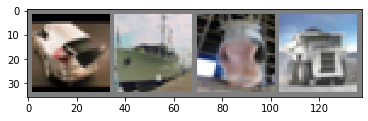

  car  ship horse truck


In [3]:
def imshow(img):
    img = img/2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [25]:
for epoch in range(2):
    
    running_loss = 0.0
    
    for i,data in enumerate(trainloader, 0):
        inputs, labels = data
        
        optimizer.zero_grad()
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss/2000))
            running_loss = 0.0

print('Finished Training')

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

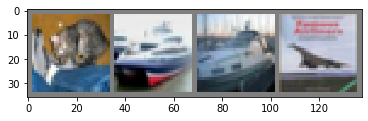

GroundTruth:    cat  ship  ship plane


In [11]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [12]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [13]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship   car  ship


In [14]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100*correct/total))

Accuracy of the network on the 10000 test images: 56 %


In [16]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100*class_correct[i]/class_total[i]))

Accuracy of plane : 55 %
Accuracy of   car : 65 %
Accuracy of  bird : 44 %
Accuracy of   cat : 44 %
Accuracy of  deer : 36 %
Accuracy of   dog : 56 %
Accuracy of  frog : 66 %
Accuracy of horse : 54 %
Accuracy of  ship : 68 %
Accuracy of truck : 69 %


# GPU

In [101]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


In [107]:
net

Net(
  (fc1): Linear(in_features=10, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [104]:
net = Net()
net.to(device)

optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [28]:
def gpu_train():
    
    for epoch in range(2):

        running_loss = 0.0

        for i,data in enumerate(trainloader, 0):
            #inputs, labels = data[0].to(device), data[1].to(device)
            inputs, labels = data
            
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 2000 == 1999:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i+1, running_loss/2000))
                running_loss = 0.0

    print('Finished Training')

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        
        for i in range(4):
            label = labels[j]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100*class_correct[i]/class_total[i]))

# DQN PyTorch

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)

cuda


In [6]:
class Red(nn.Module):
    
    def __init__(self, num_entradas = 10, n1 = 256, n2 = 256, num_salidas = 10):
        super(Red, self).__init__()
        self.loss = nn.MSELoss()
        
        self.fc1 = nn.Linear(num_entradas, n1)
        self.fc2 = nn.Linear(n1, n2)
        self.fc3 = nn.Linear(n2, num_salidas)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        
        for s in size:
            num_features *= s
        return num_features

/home/hero/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100% (2000 of 2000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (500 of 500) |######################| Elapsed Time: 0:07:32 Time:  0:07:32


Total training time:  453.69 seconds


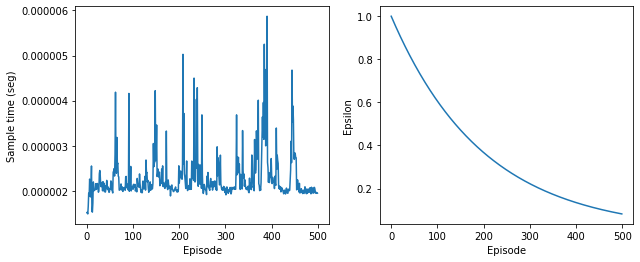

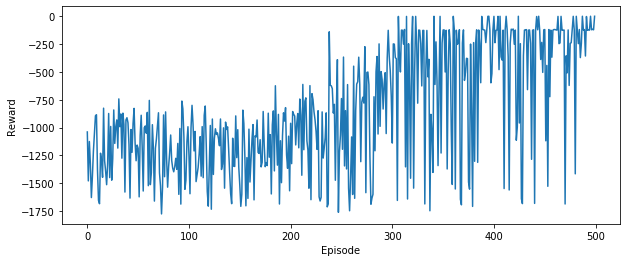

In [7]:
np.random.seed(123)

buffer = ExperienceReplay(tamano_minimo = 2000)

num_estados = 3
num_acciones = 41
tasa = 0.05

red = Red(num_entradas = num_estados, num_salidas = num_acciones)
red.to(device)

red_target = Red(num_entradas = num_estados, num_salidas = num_acciones)
red_target.to(device)

optimizer = optim.SGD(red.parameters(), lr = tasa)

num_episodes = 500
num_steps = 500
epsilon = 1.0
epsilon_decay = 0.995
tao = 0.001
gamma = 0.99
batch_size = 32

total_steps_log = []
epsilon_log = []
muestras_log = []
rewards_acumulados = []

#Entrenamiento

envName = 'Pendulum-v0'
env = gym.make(envName) 

state = env.reset()

state[2] *= 1/8.0
state = np.reshape(state, (1,-1))

initial_time = time.time()

for s in progressbar.progressbar(range(buffer.tamano_minimo)):
    action = np.random.randint(num_acciones)
    
    next_state, reward, done, info = env.step([(action-20.0)/10.0])
    next_state[2] *= 1/8.0
    next_state = np.reshape(next_state, (1, -1))
    
    buffer.agregarDato(state, action, reward, next_state, done)
    
    state = next_state

for e in progressbar.progressbar(range(num_episodes)):
    state = env.reset()
    state[2] *= 1/8.0
    state = np.reshape(state, (1, -1))
    
    rewardAcumulado = 0
    
    for s in range(num_steps):
        if(np.random.random() <= epsilon):
            action = np.random.randint(num_acciones)
        else:
            aux = torch.Tensor(state)
            aux = aux.to(device)
            _, action = torch.max(red(aux), 1)
            action = action.item()
            
        next_state, reward, done, info = env.step([(action-20.0)/10.0])
        next_state[2] *= 1/8.0
        next_state = np.reshape(next_state, (1, -1))
        
        #state = torch.from_numpy(state)
        #next_state = torch.from_numpy(next_state)
        
        buffer.agregarDato(state, action, reward, next_state, done)
        
        optimizer.zero_grad()
       
        state = next_state
        
        sumaMuestras = 0
        
        tm = time.time()
        muestras = buffer.darMuestras()
        sumaMuestras += time.time()-tm

        states = np.concatenate(muestras['St'].values)
        actions = np.array(muestras['At'].values, dtype = np.int)
        rewards = np.array(muestras['Rt+1'].values, dtype = np.float)
        next_states = np.concatenate(muestras['St+1'].values)
        dones = np.array(muestras['done'].values, dtype = np.int)

        states = torch.from_numpy(states)
        #actions = torch.from_numpy(actions)
        #rewards = torch.from_numpy(rewards)
        next_states = torch.from_numpy(next_states)
        #dones = torch.from_numpy(dones)
        
        states = states.to(device)
        #actions = actions.to(device)
        #rewards = rewards.to(device)
        next_states = next_states.to(device)
        #dones = dones.to(device)
        
        #Q_values = red.predict(states)
        Q_values = red(states.float())
        
        #next_Q_values = red_target.predict(next_states)
        next_Q_values = red_target(next_states.float())
        
        targets = Q_values.cpu().detach().numpy().copy()   # Set initial target values
        
        next_Q_values = next_Q_values.cpu().detach().numpy()

        targets[np.arange(buffer.tamano_batch), list(actions)] = rewards + gamma* np.max(next_Q_values, axis = 1) * (1 - dones)
        
        targets = torch.Tensor(targets)
        targets = targets.to(device)
        
        #red.train_on_batch(states, targets)
        #actualizarRedTarget(red, red_target)
        
        loss = red.loss(Q_values, targets)
        loss.backward()
        optimizer.step()
        
        pesos_target = {key: w1*tao + w2*(1-tao) for [key, w1], [_ ,w2] in zip(red.state_dict().items(), red_target.state_dict().items())}
        
        red_target.load_state_dict(pesos_target, strict = True)
        
        rewardAcumulado += reward
        
        if(done):
            break    
    
    sumaMuestras *= 1/float(s)
    muestras_log.append(sumaMuestras)
    rewards_acumulados.append(rewardAcumulado)
    
    total_steps_log.append(s)
    epsilon_log.append(epsilon)
    epsilon = epsilon_decay * epsilon

total_training_time = time.time() - initial_time

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(muestras_log)
plt.xlabel('Episode')
plt.ylabel('Sample time (seg)')

plt.subplot(122)
plt.plot(epsilon_log)
plt.xlabel('Episode')
plt.ylabel('Epsilon')

plt.figure(figsize=(10,4))
plt.plot(rewards_acumulados)
plt.xlabel('Episode')
plt.ylabel('Reward')

print('Total training time: ', np.round(total_training_time, 2), 'seconds')

# Probando el Agente

In [23]:
steps_prueba = 50

state = env.reset()

for s in range(steps_prueba):
    
    state[2] *= 1/8.0
    state = np.reshape(state, (1, -1))
    
    aux_state = torch.Tensor(state)
    aux_state = aux_state.to(device)
    
    _, action = torch.max(red(aux_state), 1)
    state, reward, done, info = env.step([(action.item()-20.0)/10.0])
    
    env.render()
    time.sleep(0.1)
env.close()